In [267]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, roc_auc_score,accuracy_score
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
le = LabelEncoder()

In [268]:
train = pd.read_csv('train_ctrUa4K.csv',sep=',')
train['Loan_Status'] = le.fit_transform(train['Loan_Status'])
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1


In [269]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null int32
dtypes: float64(4), int32(1), int64(1), object(7)
memory usage: 60.0+ KB


In [270]:
test = pd.read_csv('test_lAUu6dG.csv',sep=',')
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [271]:
test['Loan_Status'] = -1
# for column in train.columns:
#     print(column,train[column].nunique(),test[column].nunique())

In [272]:
df_all = pd.concat([train,test])
del df_all['Loan_ID']
df_all.reset_index(drop=True,inplace=True)
df_all.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1


In [273]:
obj = ['Gender', 'Education', 'Married', 'Self_Employed', 'Property_Area','Dependents']
num = ['LoanAmount', 'Credit_History', 'Loan_Amount_Term']
def na_filler(df):
    for col in obj:
        df[col].fillna('missing',inplace=True)
    for col in num:
        df[col].fillna(-1,inplace=True)
        
na_filler(df_all)

In [274]:
# df_all.isnull().sum()

In [275]:

cat_cols = ['Gender',
            'Married',
            'Education',
            'Self_Employed',
            'Property_Area',
            'Dependents']
df_all[cat_cols] = df_all[cat_cols].apply(lambda col: le.fit_transform(col))
df_all.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849,0.0,-1.0,360.0,1.0,2,1
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1


In [276]:
#feature generation.
df_all['CombinedIncome'] = df_all['ApplicantIncome']+df_all['CoapplicantIncome']
df_all['Loan_Income_Ratio'] = (df_all.loc[df_all['LoanAmount']>=0,'LoanAmount']*1000)/df_all.loc[df_all['LoanAmount']>=0,'CombinedIncome'] 
df_all['Loan_Per_Month'] = (df_all.loc[(df_all['LoanAmount']>=0)&(df_all['Loan_Amount_Term']>=0),'LoanAmount']*1000)/df_all.loc[(df_all['LoanAmount']>=0)&(df_all['Loan_Amount_Term']>=0),'Loan_Amount_Term']
df_all['Loan_Income_Ratio'].fillna(-1,inplace=True)
df_all['Loan_Per_Month'].fillna(-1,inplace=True)
df_all.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,CombinedIncome,Loan_Income_Ratio,Loan_Per_Month
0,1,0,0,0,0,5849,0.0,-1.0,360.0,1.0,2,1,5849.0,-1.000000,-1.000000
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0,6091.0,21.014612,355.555556
2,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1,3000.0,22.000000,183.333333
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1,4941.0,24.286582,333.333333
4,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1,6000.0,23.500000,391.666667


In [277]:
train = df_all[df_all['Loan_Status']!=-1]
train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,CombinedIncome,Loan_Income_Ratio,Loan_Per_Month
0,1,0,0,0,0,5849,0.0,-1.0,360.0,1.0,2,1,5849.0,-1.000000,-1.000000
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0,6091.0,21.014612,355.555556
2,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1,3000.0,22.000000,183.333333
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1,4941.0,24.286582,333.333333
4,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1,6000.0,23.500000,391.666667


In [278]:
test = df_all[df_all['Loan_Status']==-1]
del test['Loan_Status']
test.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,CombinedIncome,Loan_Income_Ratio,Loan_Per_Month
614,1,1,0,0,0,5720,0.0,110.0,360.0,1.0,2,5720.0,19.230769,305.555556
615,1,1,1,0,0,3076,1500.0,126.0,360.0,1.0,2,4576.0,27.534965,350.000000
616,1,1,2,0,0,5000,1800.0,208.0,360.0,1.0,2,6800.0,30.588235,577.777778
617,1,1,2,0,0,2340,2546.0,100.0,360.0,-1.0,2,4886.0,20.466639,277.777778
618,1,0,0,1,0,3276,0.0,78.0,360.0,1.0,2,3276.0,23.809524,216.666667


In [279]:
y = train[['Loan_Status']]
del train['Loan_Status']
X = train
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=1,shuffle=True,stratify=y)

In [280]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 1 columns):
Loan_Status    614 non-null int64
dtypes: int64(1)
memory usage: 9.6 KB


In [281]:
def xgb_classifier(X_train, X_cv, y_train, y_cv, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    alg = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        objective='binary:logistic', nthread=4, seed=1)

    if useTrainCV:
        print("Start Feeding Data")
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    print('Start Training')
    alg.fit(X_train, y_train, eval_metric='auc')

    print("Start Predicting")
    predictions = alg.predict(X_cv)
    pred_proba = alg.predict_proba(X_cv)[:, 1]
#     print(predictions)
    print("Acc.score : %.4g" % accuracy_score(y_cv, predictions))
    print("AUC): %f" % roc_auc_score(y_cv, pred_proba))
    print("recall_score): %f" % recall_score(y_cv, predictions))

    feat_imp = alg.feature_importances_
    feat = X_train.columns.tolist()
    # clf.best_estimator_.booster().get_fscore()
    res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)
    res_df.plot('Features', 'Importance', kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    print(res_df)
    print(res_df["Features"].tolist())

Start Feeding Data
Start Training
Start Predicting
Acc.score : 0.7987
AUC): 0.794025
recall_score): 0.933962


C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


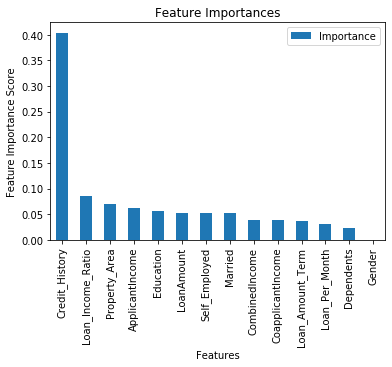

             Features  Importance
9      Credit_History    0.403850
12  Loan_Income_Ratio    0.084796
10      Property_Area    0.069241
5     ApplicantIncome    0.061630
3           Education    0.056992
7          LoanAmount    0.052858
4       Self_Employed    0.052135
1             Married    0.051335
11     CombinedIncome    0.039515
6   CoapplicantIncome    0.037759
8    Loan_Amount_Term    0.037059
13     Loan_Per_Month    0.030747
2          Dependents    0.022083
0              Gender    0.000000
['Credit_History', 'Loan_Income_Ratio', 'Property_Area', 'ApplicantIncome', 'Education', 'LoanAmount', 'Self_Employed', 'Married', 'CombinedIncome', 'CoapplicantIncome', 'Loan_Amount_Term', 'Loan_Per_Month', 'Dependents', 'Gender']


In [282]:
xgb_classifier(X_train, X_cv, y_train, y_cv)